In [1]:
import numpy as np
import tcbench as tcb
import faiss
import matplotlib.pyplot as plt

In [2]:
vectors_baseline = np.load('artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('artifacts-mirage19/baseline_labels.npy')

vectors_embeddings = np.load('artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('artifacts-mirage19/embeddings_labels.npy')

In [3]:
df_split = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10, split=True)
train_val_indices = np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]])
test_indices = df_split.iloc[0][2]

In [4]:
def build_faiss_index(data, labels, train_indices, distance_type, samples_per_class = None):
    np.random.seed(42)

    filtered_data = data[train_indices]
    filtered_labels = labels[train_indices]
    d = filtered_data.shape[1]

    selected_data = []
    selected_indices = []
    unique_labels = np.unique(filtered_labels)
    for label in unique_labels:
        label_indices = np.where(filtered_labels == label)[0]
        if samples_per_class is None or samples_per_class == -1:
            selected_label_indices = label_indices
        else:
            selected_label_indices = np.random.choice(label_indices, size=min(samples_per_class, len(label_indices)), replace=False)
        selected_data.append(filtered_data[selected_label_indices])
        selected_indices.extend(train_indices[selected_label_indices])
    selected_data = np.vstack(selected_data)
    selected_indices = np.array(selected_indices)

    if distance_type == 'euclidean':
        index = faiss.IndexFlatL2(d)
    elif distance_type == 'cosine':
        selected_data = selected_data / np.linalg.norm(selected_data, axis=1, keepdims=True)
        index = faiss.IndexFlatIP(d)
    else:
        raise ValueError("Unsupported distance type. Use 'euclidean' or 'cosine'.")

    index.add(selected_data)
    return index, selected_indices

In [5]:
def search_and_compare_labels(data, labels, test_indices, selected_indices, index, metric, limit=None):
    k = 1
    if metric == "distance":
        D, I = index.search(data[test_indices], k)
    elif metric == "similarity":
        query_vectors = data[test_indices]
        query_vectors = query_vectors / np.linalg.norm(query_vectors, axis=1, keepdims=True)
        D, I = index.search(query_vectors, k)
    
    test_labels = labels[test_indices]
    neighbor_labels = labels[selected_indices[I.flatten()]].reshape(I.shape)
    
    matches = 0
    classified = 0
    min_distances = []

    for i in range(len(test_labels)):  
        if metric == "distance":
            min_distances.append(np.sqrt(D[i,0]))
            if limit is not None and np.sqrt(D[i, 0]) > limit:
                continue
        if metric == "similarity":
            min_distances.append(D[i,0])
            if limit is not None and D[i, 0] < limit:
                continue
        classified += 1
        matches += test_labels[i] in neighbor_labels[i, :1]

    classified_percentage = (classified / len(test_labels)) * 100
    match_percentage = (matches / classified) * 100 if classified > 0 else 0
    return classified_percentage, match_percentage, min_distances

In [6]:
test_index_baseline, test_selected_indices_baseline = build_faiss_index(vectors_baseline[:2], labels_baseline[:2], np.array([0]), 'euclidean', None)
test_classified_percentage_baseline, test_match_percentage_baseline, test_min_distances_baseline = search_and_compare_labels(vectors_baseline[:2], labels_baseline[:2], np.array([1]), test_selected_indices_baseline, test_index_baseline, "distance", None)
test_min_distances_baseline

[1.0193273]

In [7]:
test_index_embeddings, test_selected_indices_embeddings = build_faiss_index(vectors_embeddings[:2], labels_embeddings[:2], np.array([0]), 'euclidean', None)
test_classified_percentage_embeddings, test_match_percentage_embeddings, test_min_distances_embeddings = search_and_compare_labels(vectors_embeddings[:2], labels_embeddings[:2], np.array([1]), test_selected_indices_embeddings, test_index_embeddings, "distance", None)
test_min_distances_embeddings

[3.612618]

In [8]:
test_index_embeddings_cosine, test_selected_indices_embeddings_cosine = build_faiss_index(vectors_embeddings[:2], labels_embeddings[:2], np.array([0]), 'cosine', None)
test_classified_percentage_embeddings_cosine, test_match_percentage_embeddings_cosine, test_min_distances_embeddings_cosine = search_and_compare_labels(vectors_embeddings[:2], labels_embeddings[:2], np.array([1]), test_selected_indices_embeddings_cosine, test_index_embeddings_cosine, "similarity", None)
test_min_distances_embeddings_cosine

[0.7772217]

In [9]:
index_baseline, selected_indices_baseline = build_faiss_index(vectors_baseline, labels_baseline, train_val_indices, 'euclidean', None)
classified_percentage_baseline, match_percentage_baseline, min_distances_baseline = search_and_compare_labels(vectors_baseline, labels_baseline, test_indices, selected_indices_baseline, index_baseline, "distance", None)
print("Baseline - Classified Percentage:", classified_percentage_baseline)
print("Baseline - Match Percentage:", match_percentage_baseline)

Baseline - Classified Percentage: 100.0
Baseline - Match Percentage: 63.867248363976316


In [10]:
index_embeddings, selected_indices_embeddings = build_faiss_index(vectors_embeddings, labels_embeddings, train_val_indices, 'euclidean', None)
classified_percentage_embeddings, match_percentage_embeddings, min_distances_embeddings = search_and_compare_labels(vectors_embeddings, labels_embeddings, test_indices, selected_indices_embeddings, index_embeddings, "distance", None)
print("Embeddings - Classified Percentage:", classified_percentage_embeddings)  
print("Embeddings - Match Percentage:", match_percentage_embeddings)

Embeddings - Classified Percentage: 100.0
Embeddings - Match Percentage: 79.38610158928014


In [11]:
index_embeddings_cosine, selected_indices_embeddings_cosine = build_faiss_index(vectors_embeddings, labels_embeddings, train_val_indices, 'cosine', None)
classified_percentage_embeddings_cosine, match_percentage_embeddings_cosine, min_distances_embeddings_cosine = search_and_compare_labels(vectors_embeddings, labels_embeddings, test_indices, selected_indices_embeddings_cosine, index_embeddings_cosine, "similarity", None)
print("Embeddings Cosine - Classified Percentage:", classified_percentage_embeddings_cosine)    
print("Embeddings Cosine - Match Percentage:", match_percentage_embeddings_cosine)

Embeddings Cosine - Classified Percentage: 100.0
Embeddings Cosine - Match Percentage: 80.91305702711125


In [12]:
def extract_results(vectors, labels, train_indices, test_indices, distance_type, metric, samples, limits):
    classified_results = {li: [] for li in limits}
    accuracy_results = {li: [] for li in limits}

    for limit in limits:
        for sample_size in samples:
            index, selected_indices = build_faiss_index(
                vectors, labels, train_indices, distance_type, sample_size
            )
            classified, accuracy, min_distances = search_and_compare_labels(
                vectors, labels, test_indices, selected_indices, index, metric, limit
            )
            classified_results[limit].append(classified)
            accuracy_results[limit].append(accuracy)   
    return classified_results, accuracy_results, min_distances

In [13]:
def plot_results_by_distance(classified_results, accuracy_results, samples, distances):
    num_distances = len(distances)
    fig, axes = plt.subplots((num_distances + 1) // 2, 2, figsize=(12, 4 * ((num_distances + 1) // 2)), sharex=True)

    axes = axes.flatten()

    for i, distance in enumerate(distances):
        ax = axes[i]
        
        ax.plot(samples, accuracy_results[distance], label='Accuracy', color='blue')
        ax.set_xlabel('Number of Samples Per Class') 
        ax.set_ylabel('Accuracy (%)', color='blue')   
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_ylim(0, 100)
        ax.set_title(f'Distance: {distance}')
        ax.grid(True)
        
        ax2 = ax.twinx()
        ax2.plot(samples, classified_results[distance], label='Classified %', color='green', linestyle='--')
        ax2.set_xlabel('Number of Samples Per Class')
        ax2.set_ylabel('Classified Percentage (%)', color='green')
        ax2.set_ylim(0, 100)
        ax2.tick_params(axis='y', labelcolor='green')
        
        # # Add legends
        # ax.legend(loc='upper left')
        # ax2.legend(loc='upper right')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

In [14]:
samples = [5,10,20,30,40,50,60,70,80,90,100,200,300,400,
            500,600,700,800,900,1000,2000,3000,4000,5000]

distances_baseline = [0.005, 0.01, 0.05, 0.1]
distances_embeddings = [0.05, 0.1, 0.5, 1]
similarities = [0.9, 0.95, 0.99, 0.995]

BASELINE plots using EUCLIDEAN DISTANCE
The X-axis is the number of samples per class
There are two Y-axes: the left one is the accuracy and the right one is the classified percentage
These have been graphed across 4 distance values

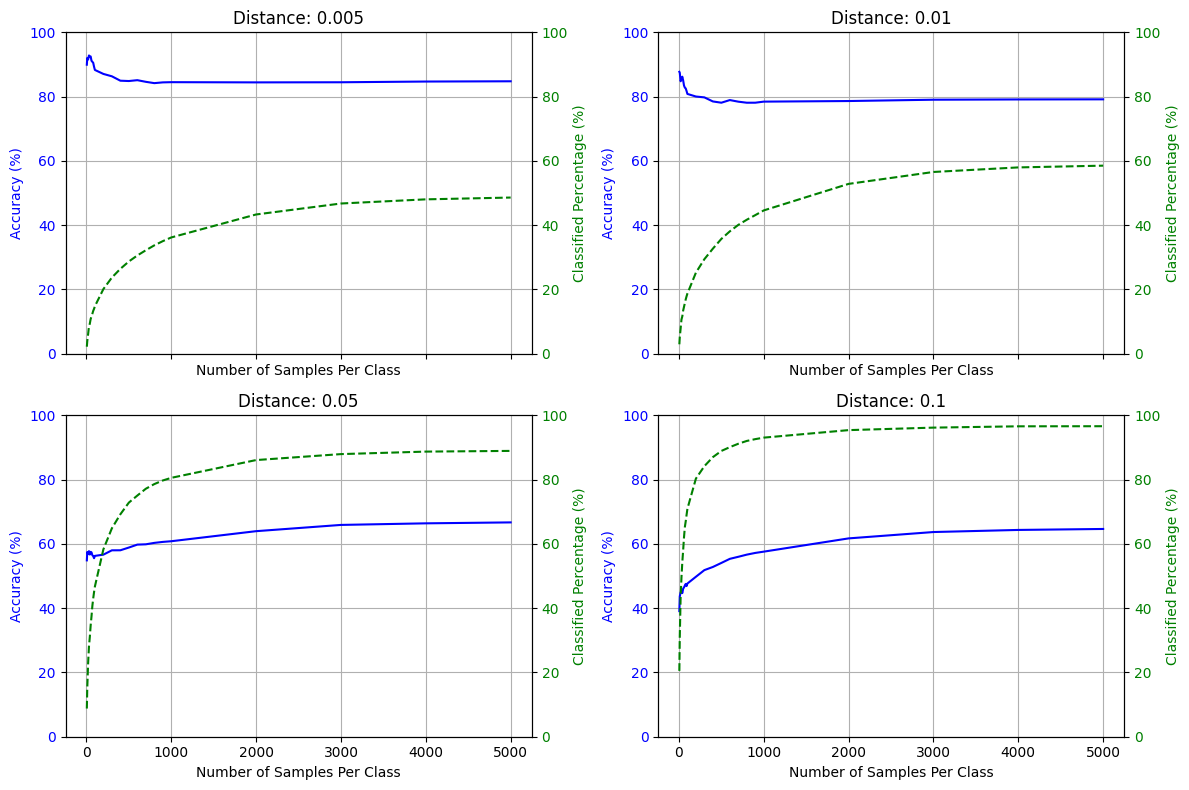

In [15]:
classified_results_baseline, accuracy_results_baseline, min_distances_baseline = extract_results(vectors_baseline, labels_baseline, train_val_indices, test_indices, 'euclidean', 'distance', samples, distances_baseline)
plot_results_by_distance(classified_results_baseline, accuracy_results_baseline, samples, distances_baseline)

EMBEDDINGS plots using EUCLIDEAN DISTANCE
The X-axis is the number of samples per class
There are two Y-axes: the left one is the accuracy and the right one is the classified percentage
These have been graphed across 4 distance values

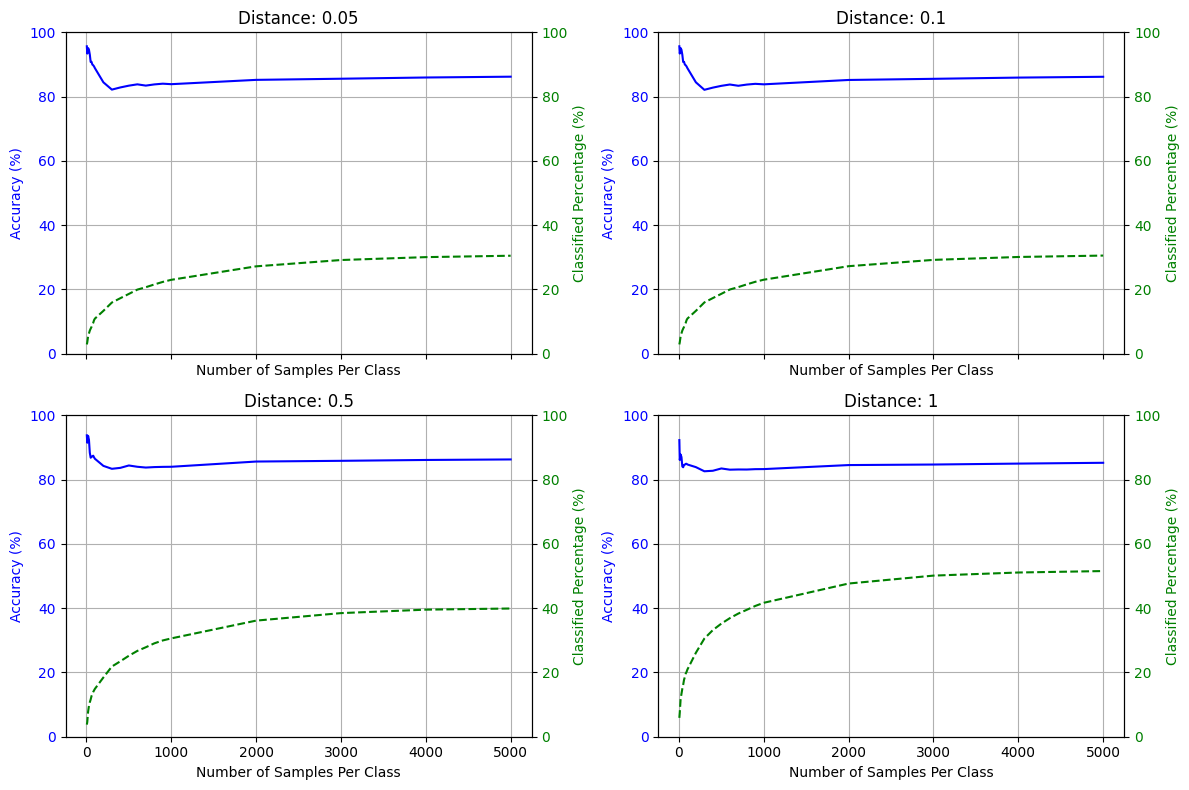

In [16]:
classified_results_embeddings, accuracy_results_embeddings, min_distances_embeddings = extract_results(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'euclidean', 'distance', samples, distances_embeddings)
plot_results_by_distance(classified_results_embeddings, accuracy_results_embeddings, samples, distances_embeddings)

EMBEDDINGS plots using COSINE SIMILARITY
The X-axis is the number of samples per class
There are two Y-axes: the left one is the accuracy and the right one is the classified percentage
These have been graphed across 4 distance values

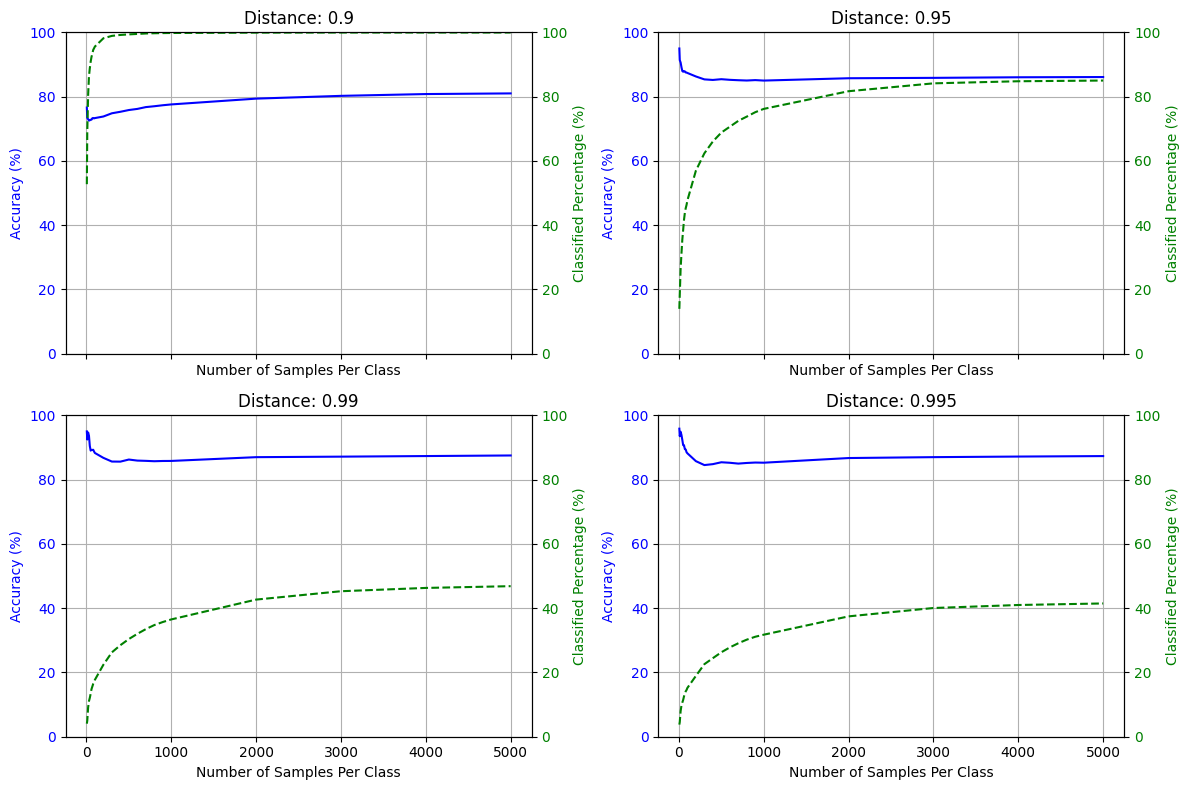

In [17]:
classified_results_embeddings_cosine, accuracy_results_embeddings_cosine, min_distances_embeddings_cosine = extract_results(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'cosine', 'similarity', samples, similarities)
plot_results_by_distance(classified_results_embeddings_cosine, accuracy_results_embeddings_cosine, samples, similarities)

In [18]:
def plot_results_by_sample_size(classified_results, accuracy_results, samples, distances):
    num_samples = len(samples)
    fig, axes = plt.subplots((num_samples + 1) // 2, 2, figsize=(12, 4 * ((num_samples + 1) // 2)), sharex=True)

    axes = axes.flatten()

    for i, sample_size in enumerate(samples):
        ax = axes[i]

        classified = [classified_results[distance][i] for distance in distances]
        accuracy = [accuracy_results[distance][i] for distance in distances]

        ax.plot(distances, accuracy, label='Accuracy', color='blue')
        ax.set_xlabel('Distance')
        ax.set_ylabel('Accuracy (%)', color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_ylim(0, 100)
        ax.set_title(f'Sample Size: {sample_size}')
        ax.grid(True)

        ax2 = ax.twinx()
        ax2.plot(distances, classified, label='Classified %', color='green', linestyle='--')
        ax2.set_ylabel('Classified Percentage (%)', color='green')
        ax2.set_ylim(0, 100)
        ax2.tick_params(axis='y', labelcolor='green')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [19]:
samples = [5,10,25,50,75,100, 500, 1000]

distances_baseline = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
distances_embeddings = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
                        1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
similarities = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 
                0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]

BASELINE plots using EUCLIDEAN DISTANCE
The X-axis is the distance
There are two Y-axes: the left one is the accuracy and the right one is the classified percentage
These have been graphed across 8 sample sizes (i.e. the number of samples per class in the database)

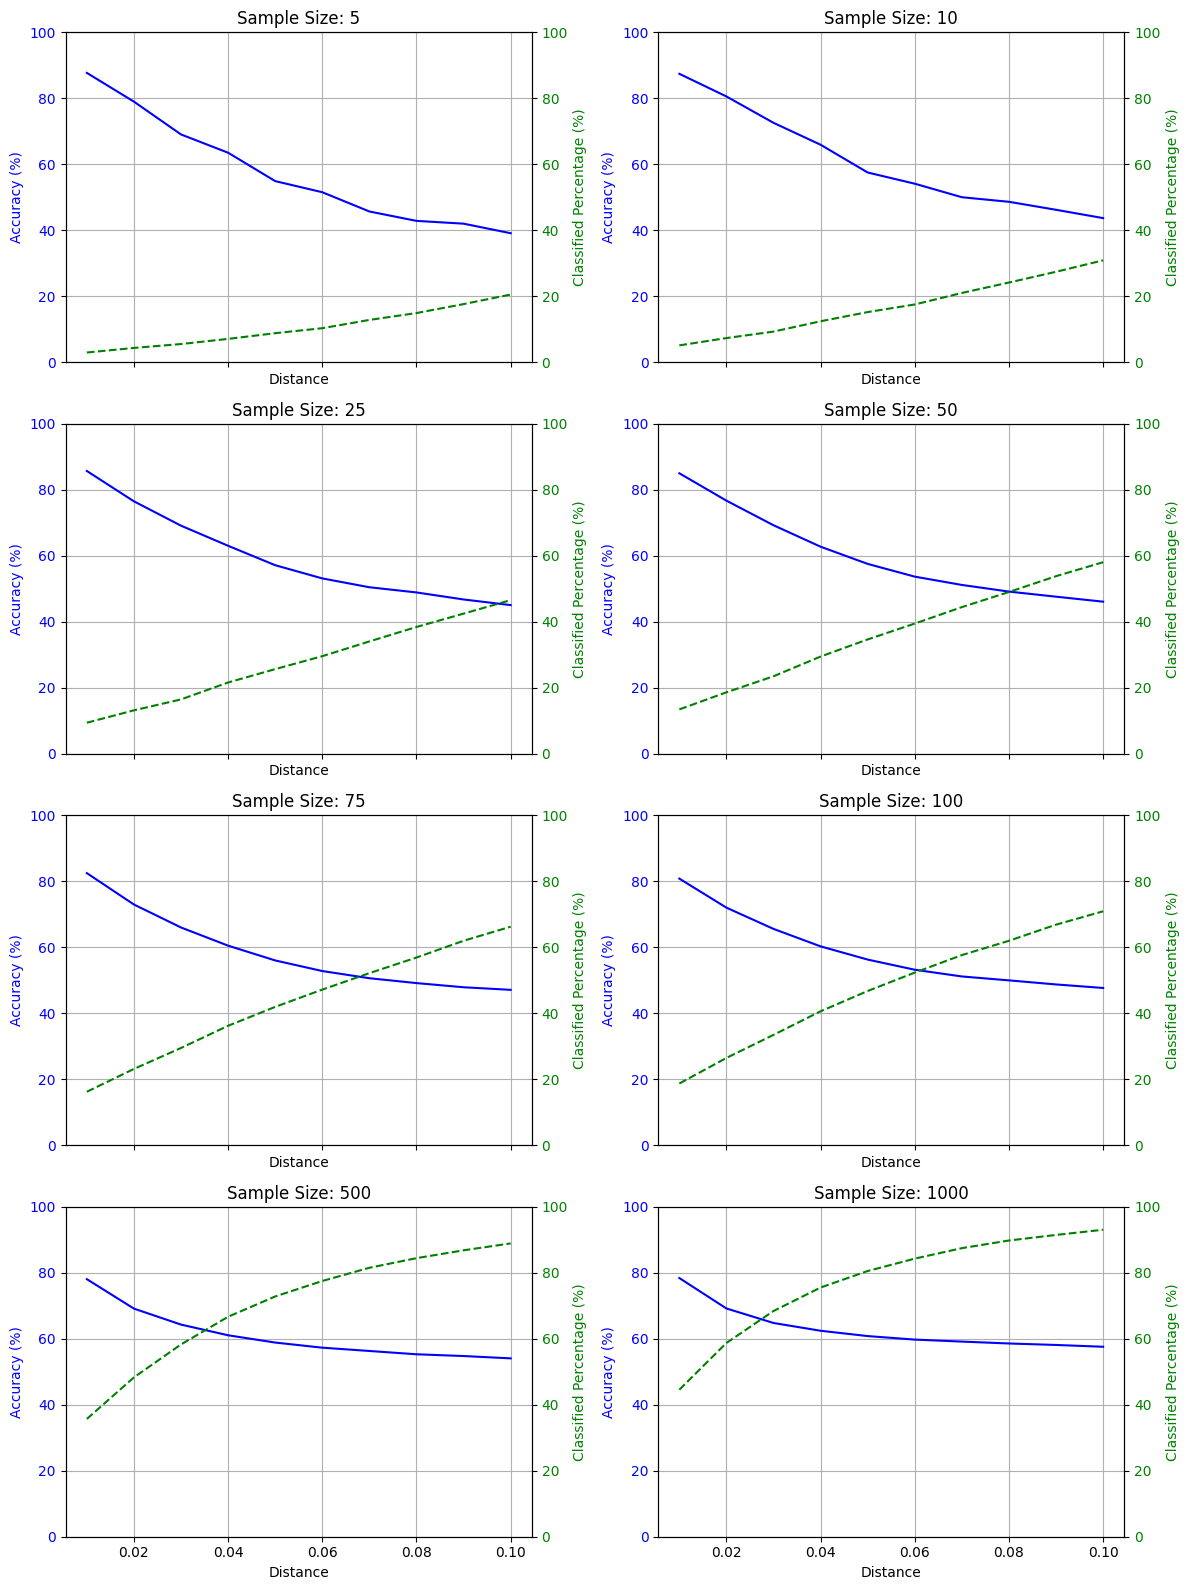

In [20]:
classified_results_baseline, accuracy_results_baseline, min_distances_baseline = extract_results(vectors_baseline, labels_baseline, train_val_indices, test_indices, 'euclidean', 'distance', samples, distances_baseline)
plot_results_by_sample_size(classified_results_baseline, accuracy_results_baseline, samples, distances_baseline)

SOME NOTES
With 100% classifed and no distance we had 63.9% accuracy
We can see that as the number deteriorates with larger distances
Higher accuracy however comes at the expense of a lower classified percentage
____________________________________________________________________________________________

EMBEDDINGS plots using EUCLIDEAN DISTANCE
The X-axis is the distance
There are two Y-axes: the left one is the accuracy and the right one is the classified percentage
These have been graphed across 8 sample sizes (i.e. the number of samples per class in the database)

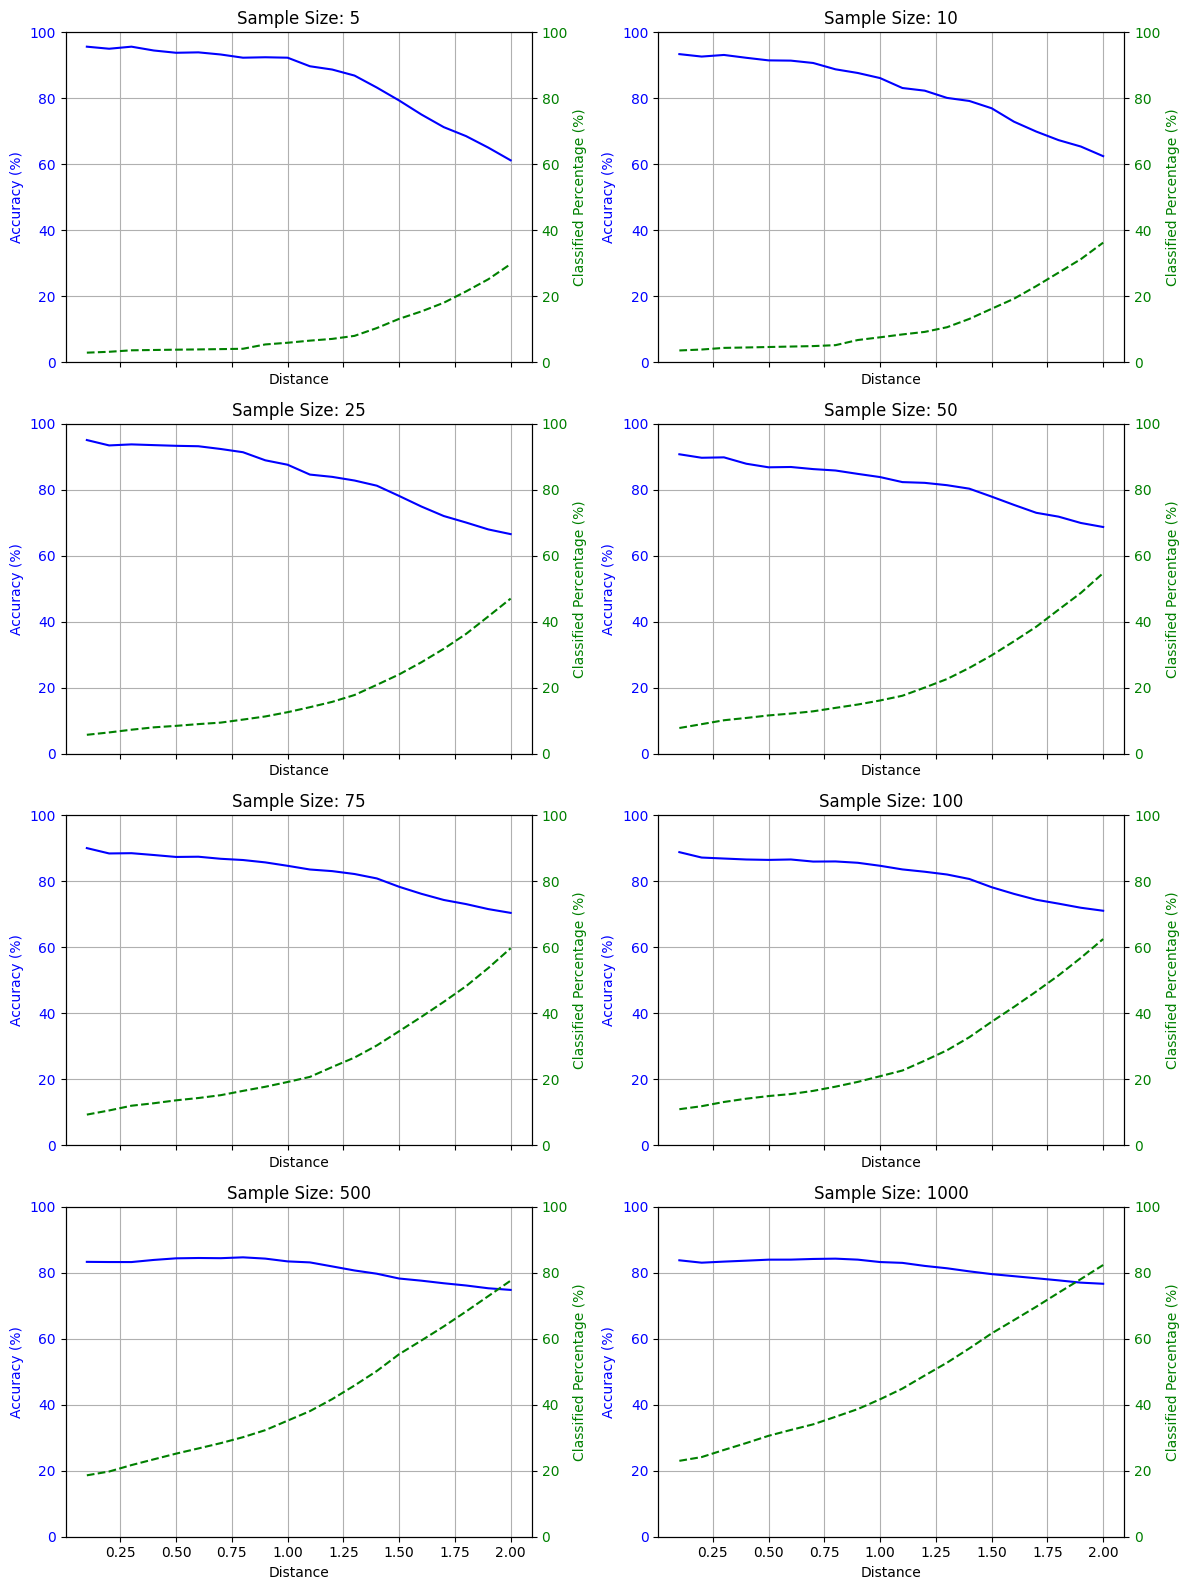

In [21]:
classified_results_embeddings, accuracy_results_embeddings, min_distances_embeddings = extract_results(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'euclidean', 'distance', samples, distances_embeddings)
plot_results_by_sample_size(classified_results_embeddings, accuracy_results_embeddings, samples, distances_embeddings)

SOME NOTES
With 100% classifed and no distance we had 79.4% accuracy
We can again see that as the number deteriorates with larger distances
But the line is not as straight
There definitely seems to be points where the accuracy is well above 80%.
The classified percentage is still quite low though, usually <50%.
____________________________________________________________________________________________

EMBEDDINGS plots using COSINE SIMILARITY
The X-axis is the distance
There are two Y-axes: the left one is the accuracy and the right one is the classified percentage
These have been graphed across 8 sample sizes (i.e. the number of samples per class in the database)

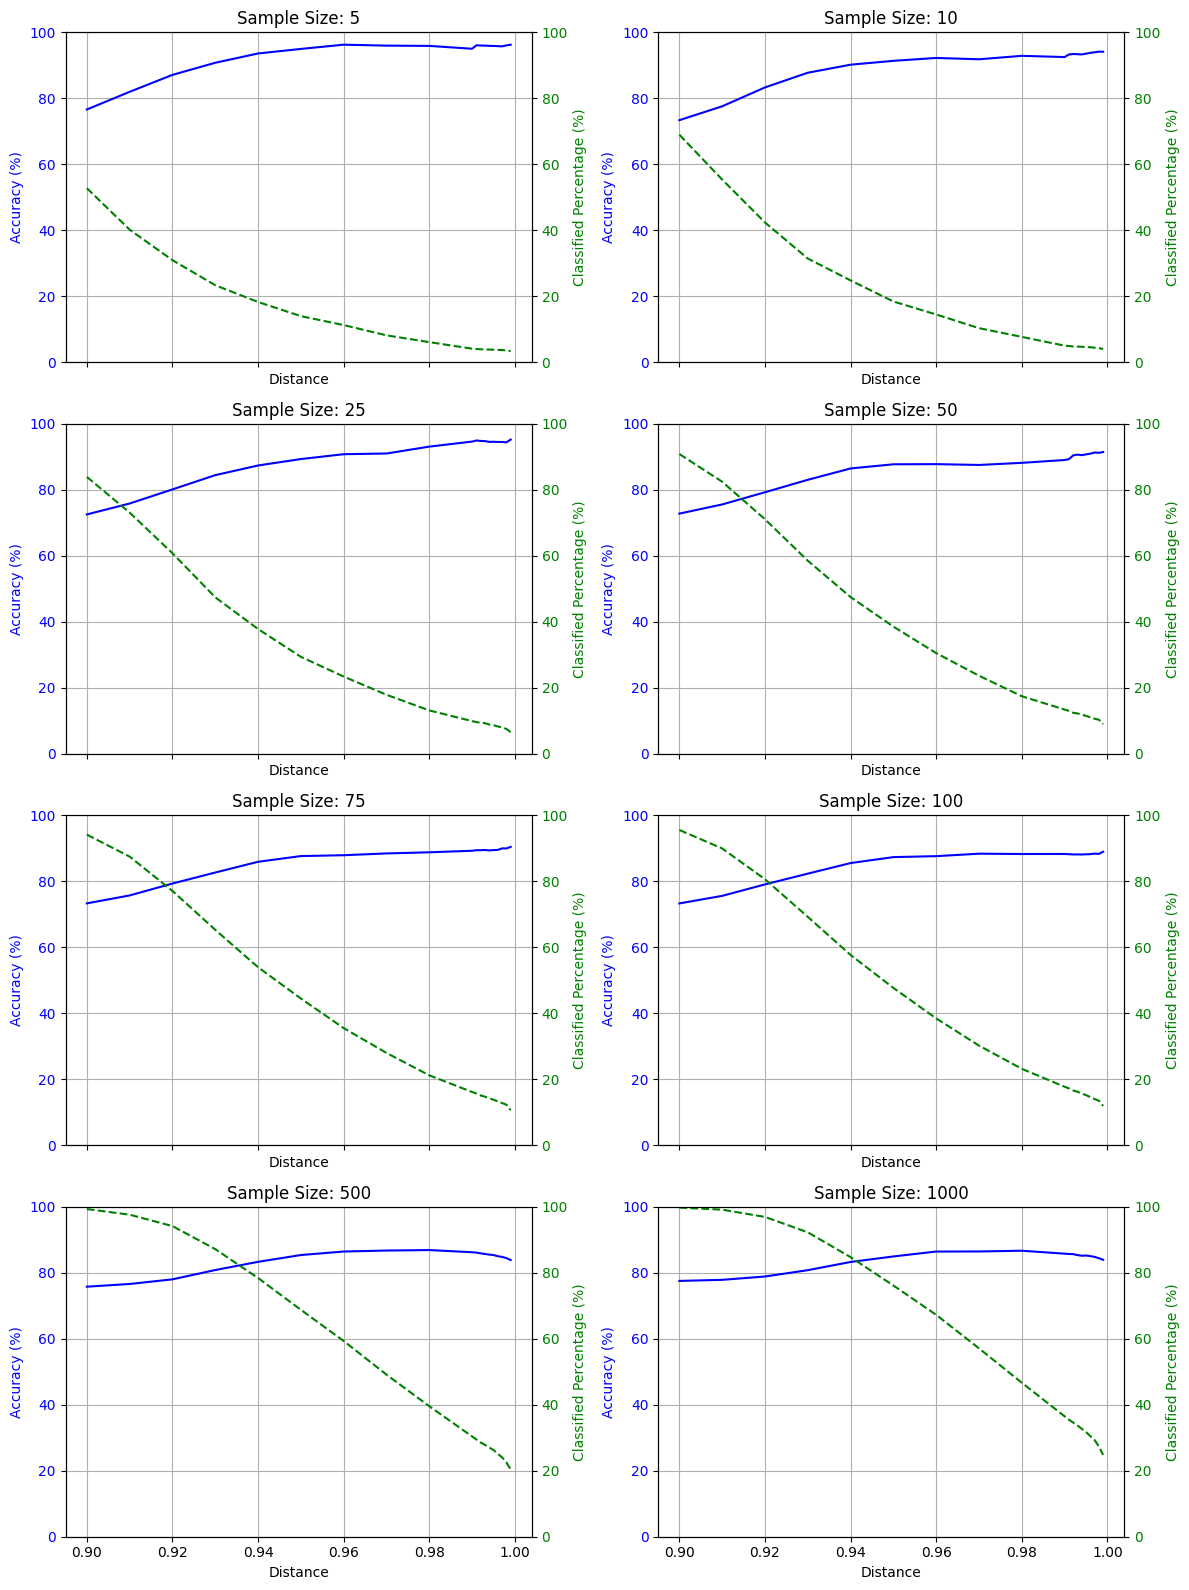

In [22]:
classified_results_embeddings_cosine, accuracy_results_embeddings_cosine, min_distances_embeddings_cosine = extract_results(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'cosine', 'similarity', samples, similarities)
plot_results_by_sample_size(classified_results_embeddings_cosine, accuracy_results_embeddings_cosine, samples, similarities)

SOME NOTES
With 100% classifed and no distance we had 80.9% accuracy
Similar to the embeddings euclidean distance there seem to be distances at which the accuracy nears 90%.
I think there are higher classification percentages in this one though: 
    e.g. sample size 100, has accuracy above 80% but classified percentage of nearly 60%.
Still not ideal.

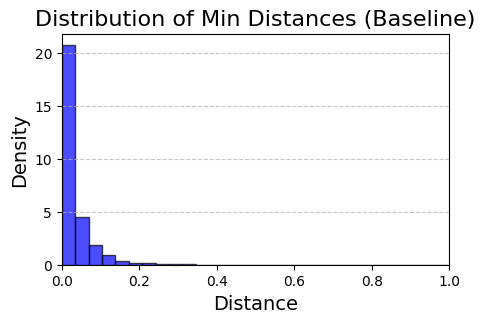

In [23]:
plt.figure(figsize=(5, 3))
plt.hist(min_distances_baseline, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Baseline)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

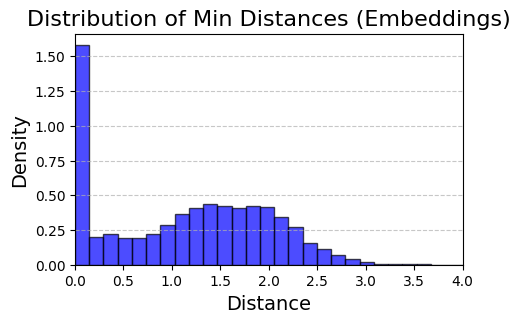

In [24]:
plt.figure(figsize=(5, 3))
plt.hist(min_distances_embeddings, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Embeddings)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

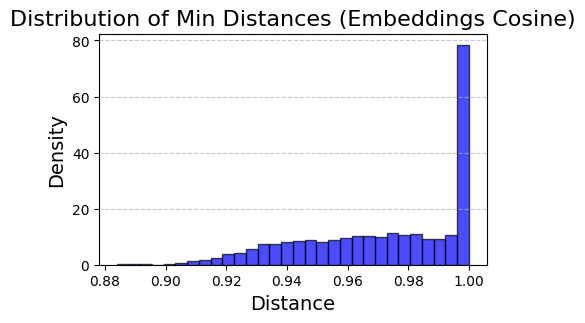

In [25]:
plt.figure(figsize=(5, 3))
plt.hist(min_distances_embeddings_cosine, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Embeddings Cosine)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()